# ANALYSIS USING LAPLACE TRANSFORMS (LTs)

This notebook demonstrates how Laplace transforms and transfer functions can be derived directly from a chemical model.

There are two considerations for the approach taken here. First, this is *not* a general technique. It only works if the underlying network can be represented by a system of linear differential equations. In practice this means that: (a) all reactions have a single reactant and (b) the kinetics are masss action.

Second, LT analysis assumes that all initial states are 0. This means that in those cases where initial state is *not* 0, special considerations are necessary/.

# Preliminaries

In [2]:
import control
import numpy as np
import matplotlib.pyplot as plt
import sympy
import tellurium as te

# Helpers

In [13]:
class PlotResult(object):

    def __init__(self, times=None, yt=None, ax=None):
        self.times = times
        self.yt = yt
        self.ax = ax
        
    def __repr__(self):
        return ""

In [14]:
def plotTF(tf, times=None, is_plot=True, figsize=(5,5)):
    if times is None:
        times = np.linspace(0, 10, 100)
    _, yt = control.forced_response(tf, T=times, U=1)
    if is_plot:
        _, ax = plt.subplots(1, figsize=figsize)
        ax.plot(times, yt)
        ax.set_xlabel("time")
    else:
        ax = None
    return PlotResult(times=times, yt=yt, ax=ax)

# Tests
tf = control.TransferFunction([1], [1, 0])
plot_result = plotTF(tf, is_plot=False)
assert(isinstance(plot_result, PlotResult))
print("OK!")

OK!


# Irreversible reaction

Consider the one step sequential pathway with mass action kinetics
$s_1 \xrightarrow{k_1 s_1} s_2$.

We want to control $s_2$ by manipulating $s_1$.
We will manipulate $s_1$ by controlling its concentration in solution.

We want the transfer function $G(s) = \frac{S_2(s)}{S_1(s)}$.

## 1. System equations

$s_1  \xrightarrow{k_1 s_1 } s_2$

So, the state equations are:
* $\dot{s}_1 = -k_1 s_1$
* $\dot{s}_2 = k_1 s_1$

## 2. LT of system equations

* $s S_1 (s) = -k_1 S_1 (s)$
* $s S_2 = k_1 S_1 (s)$

## 3. Calculate transfer function

$G(s) = \frac{S_2(s)}{S_1(s)}$. This is calculated directly
from the second system equation.

$G(s) = \frac{S_2 (s)}{S_1 (s)} = \frac{k_1}{s}$

## 4. Predict step response from TF

### 4a. Construct transfer function

The function ``control.TransferFunction`` provides a way to construct transfer functions and calculate with them.

A transfer function represented by a numerator polynomial in $s$ and a denominator polynomial in $s$.
A polynomial in $s$ is a list of floats.
The last element of the list is the coefficient for $s^0$;
element last - 1 is the coefficient for $s^1$; and so on.

For example, [1, 2, 3] represents the polynomial $s^2 + 2 s + 3$.

In [10]:
# Construct the transfer function for G(s) at k1=1
k1 = 1
G_tf = control.TransferFunction([k1], [1, 0])
G_tf

TransferFunction(array([1]), array([1, 0]))

$G(s) = \frac{2s +4}{3s^3 + 1}$

In [6]:
tf = control.TransferFunction([2, 4], [3, 0, 0, 1])
tf

TransferFunction(array([2, 4]), array([3, 0, 0, 1]))

In [5]:
tf.poles()

array([ 0.34668064+0.60046848j,  0.34668064-0.60046848j,
       -0.69336127+0.j        ])

In [7]:
tf.dcgain()

4.0

### 4b. Predict step response

Text(0.5, 0, 'time')

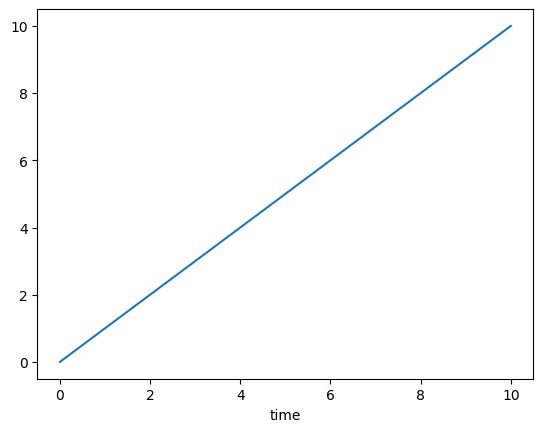

In [11]:
# Use control.forced_response
times = np.linspace(0, 10, 100)
_, yt = control.forced_response(G_tf, T=times, U=1)
plt.plot(times, yt)
plt.xlabel("time")

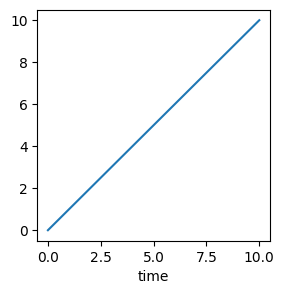

In [15]:
# We can wrap the foregoing into a function
plotTF(G_tf, figsize=(3,3))

## 5. Simulate in Antimony

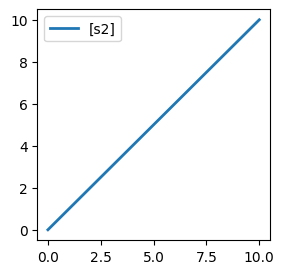

In [16]:
model = """
$s1 -> s2; k1*s1

s1 = 1
s2 = 0
k1 = 1
"""
rr = te.loada(model)
rr.simulate(0, 10, 100)
rr.plot(figsize=(3,3))

## 6: Analyze

The results look identical.

# Irreversible reaction with initial conditions

Again, consider the one step sequential pathway with mass action kinetics
$s_1 \xrightarrow{k_1 s_1} s_2$.

This time we manipulate $s_1$ by adding or removing molecules of this chemical species.
This input is $u$.

With this control mechanism, we have a slightly different chemical network.
That is, for every reaction whose reactant is $s_1$, we add
another reaction that has $u$ as the reactant, with the same kinetics constant
and product.

We want to find the transfer function $\frac{S_2(s)}{U(s)}$.

## 1. System equations

First, we write the revised chemical network:

\begin{eqnarray}
s_1  &\xrightarrow{k_1s_1 } s_2\\
& \xrightarrow{k_1 u} s_2\\
\end{eqnarray}

So, the state equations are:
* $\dot{s}_1 = -k_1 s_1$
* $\dot{s}_2 = k_1 s_1 + k_1 u$

Note that there is *no* system equation for $u$ since it is input, not state.

## 2. LT of system equations

### 2a. Inputs and outputs

* $s S_2 = k_1 (S_1 (s) + U(s))$

### 2b. Initial state

To handle a case where $s_1 (0) > 0$, we need special
considerations.
Note that in this circumstances, $s_1 (t)$ degrades as a negative
exponential.
That is, $\dot{s}_1 = - k_1 s_1$.
So, $S_1 (s) = \frac{s(0)}{(s + k_1)}$.

## 3. Calculate transfer function

### 3a. Input and output

The calculation is done assuming an initial state of 0;
that $s(0) = 0$.
$s S_2 = k_1  U(s)$
And so, $G(s) = \frac{k_1}{s}$.

### 3b. Including initial state

To analysis is done under the assumption that $u(t) = 0$.

In this case, $s_1 (t) + s_2 (t) = s(0)$.
Thus, $s_2 (t) = s_1 (0) - s_1 (0) e^{-k_1 t}$.
Taking the LT, we have
From $S_2 (s) = s(0) - \frac{s(0)}{(s + k_1)}$.

## 4. Predict step response

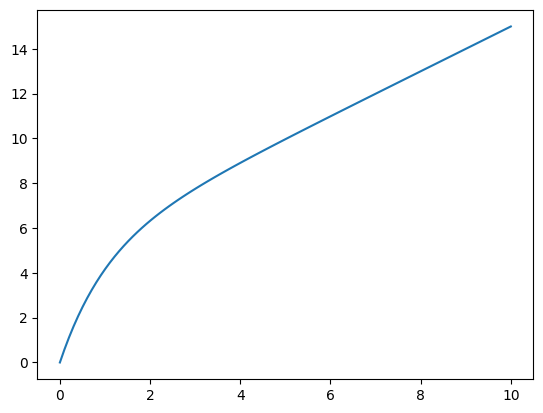

In [18]:
# Initialize constants
k1 = 1
s1_initial = 5
times = np.linspace(0, 10, 100)
# Response to input
tf = control.TransferFunction([k1], [1, 0])
_, yt = control.forced_response(tf, T=times, U=1)
# Response to initial conditions
tf_initial = control.TransferFunction([1], [1, k1])
_, y_initial = control.forced_response(tf_initial, T=times, X0=s1_initial)
y_initial = s1_initial - y_initial
# Plot the results
plt.plot(times, yt + y_initial)

## 5. Simulate in Antimony

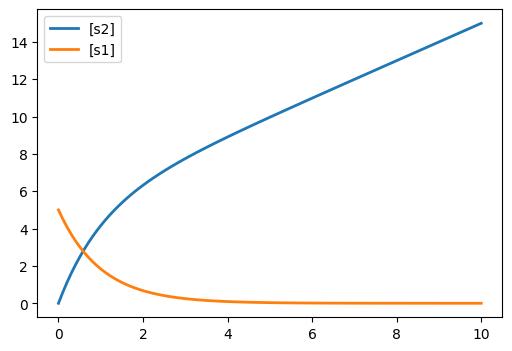

In [9]:
model = """
$u -> s2; k1*u
s1 -> s2; k1*s1

u = 1  // Step response
s2 = 0
s1 = 5
k1 = 1
"""
rr = te.loada(model)
rr.simulate(0, 10, 100)
rr.plot()

## 6. Analyze

The results of the prediction and the simulation are the same.

Here we consider a reversible reaction with 0 initial conditions. That is:

\begin{eqnarray}
s_1 & \xrightarrow{k_1 s_1} s_2 \\
u & \xrightarrow{k_1 u} s_2 \\
s_2 & \xrightarrow{k_2 s_2} s_1 \\
\end{eqnarray}

# Branching pathway controlling $s_3$


\begin{eqnarray}
s_1 & \xrightarrow{k_1 s_1} s_2 \\
s_2 & \xrightarrow{k_2 s_2} s_1 \\
s_1 & \xrightarrow{k_3 s_1} s_3 \\
 & \xrightarrow{k_1 u} s_2 \\
\end{eqnarray}

We want the transfer function from the input $u(t)$ to the output $s_3(t)$.

## 1. System equations

\begin{eqnarray}
\dot{s}_1 & = & k_2 s_2 - k_1 s_1 - k_3 s_1  \\
\dot{s}_2 & = & -k_2 s_2 + k_1 s_1 + k_1 u \\
\dot{s}_3 & = & k_3 s_1  \\
\end{eqnarray}

## 2. LT of system equations

\begin{eqnarray}
s S_1(s) & = & k_2 S_2(s) - k_1 S_1 (s) - k_3 S_1 (s)  \\
s S_2 (s) & = & -k_2 S_2 (s) + k_1 S_1 (s) + k_1 U(s) \\
s S_3(s) & = & k_3 S_1 (s) \\
\end{eqnarray}

## 3. Calculate transfer function

We want $G(s) = \frac{S_3 (s)}{U(s)}$.

We can transform the third system equation so that we have $S_1 (s)$
in terms of $S_3 (s)$. That is,

\begin{eqnarray}
s S_3(s) & = & k_3 S_1 (s) \\
S_1 (s) & = & \frac{S_3(s) s}{k_3}  \\
\end{eqnarray}

We can also express $S_2 (s)$ in terms of $U(s)$ and $S_3(s)$.
\begin{eqnarray}
s S_2 (s) & = & -k_2 S_2 (s) + k_1 S_1 (s) + k_1 U(s) \\
S_2 (s) (s + k_2) & = &  k_1 \frac{s S_3(s)}{k_3}  + k_1 U(s) \\
S_2 (s)  & = &  \frac{1}{s + k_2} \left( k_1 \frac{s S_3(s)}{k_3}  + k_1 U(s) \right) \\
\end{eqnarray}

This allows us to substitute into the second system equation to obtain
the desired result.

\begin{eqnarray}
S_1(s) (s + k_1 + k_3) & = & k_2 S_2(s) \\
\frac{sS_3(s)}{k_3}   (s + k_1 + k_3) & = & k_2 \frac{1}{s + k_2} \left( k_1 \frac{s S_3(s) }{k_3}  + k_1 U(s) \right) \\
\end{eqnarray}

In [21]:
s3, s1, s, k1, k2, k3, s2, u = sympy.symbols("s3, s1, s, k1, k2, k3, s2, u")

In [22]:
expr = s3*s/k3*(s + k1 + k3) -( k2/(s + k2)*(k1*s3*s/k3 + k1*u))
expr

-k2*(k1*u + k1*s*s3/k3)/(k2 + s) + s*s3*(k1 + k3 + s)/k3

In [25]:
sympy.solve(expr, s3)

[k1*k2*k3*u/(s*(k1*s + k2*k3 + k2*s + k3*s + s**2))]

In [33]:
s3 = sympy.solve(expr, s3)[0]
s3

k1*k2*k3*u/(s*(k1*s + k2*k3 + k2*s + k3*s + s**2))

In [35]:
print(sympy.latex(s3))

\frac{k_{1} k_{2} k_{3} u}{s \left(k_{1} s + k_{2} k_{3} + k_{2} s + k_{3} s + s^{2}\right)}


$G(s) = \frac{S_3(s)}{U(s)} = \frac{k_{1} k_{2} k_{3} }{s \left(k_{1} s + k_{2} k_{3} + k_{2} s + k_{3} s + s^{2}\right)}$

## 4. Predict step response

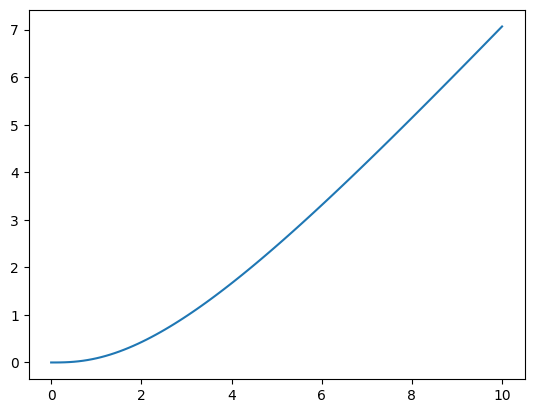

In [43]:
# Initialize constants
k1, k2, k3 = (1, 1, 1)
times = np.linspace(0, 10, 100)
# Response to input
tf = control.TransferFunction([k1*k2*k3],
                              [1, k1+k2+k3, k2*k3, 0])
_, yt = control.forced_response(tf, T=times, U=1)
# Plot the results
plt.plot(times, yt)

In [39]:
tf.poles()

array([-2.61803399+0.j, -0.38196601+0.j,  0.        +0.j])

## 5. Simulate in Antimony

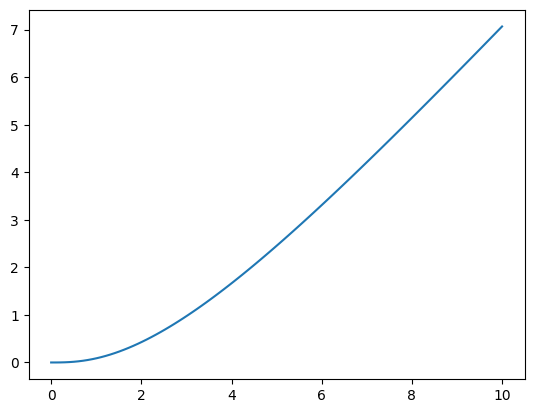

In [38]:
model = """
s1 -> s2; k1*s1
s2 -> s1; k2*s2
s1 -> s3; k3*s1
$u -> s2; k1*u

k1 = 1
k2 = 1
k3 = 1
s1 = 0
s2 = 0
s3 = 0
$u = 1
"""
rr = te.loada(model)
data = rr.simulate(0, 10, 100)
plt.plot(data["time"], data["[s3]"])

## 6. Analyze

$G(s) = \frac{S_3(s)}{U(s)} = \frac{k_{1} k_{2} k_{3} }{s \left(k_{1} s + k_{2} k_{3} + k_{2} s + k_{3} s + s^{2}\right)}$

Some observations
1. The DC gain is infinite and so we expect an unbounded effect
from a step response.
1. An infinite DC gain makes sense since mass accumulates in $S_3$.
1. The initial part of the step response is a quadratic, which results from
populating $s_1$ from $s_2$.